In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [5]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'
#thetaSTDtest
#ZcritTest
#tryMean
# dataset = pd.read_csv(datapath+'chiSecTest.csv')
dataset = pd.read_csv(datapath+'tryMean.csv')

#thetaSTDtest
# comp = pd.read_csv(datapath+'thetaSTDtest.csv')
# #remove junk columns
# comp = comp.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1','Zcrit12','Zcrit23'])

In [6]:
dataset.describe()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,ThetaSTD12,ThetaSTD23,chiSec,Zval12,Zval23,threeBRfillfac,threeBRfillstd,Tsec,instability_time,shadow_instability_time
count,102497.000000,95951.000000,95951.000000,94869.000000,102497.000000,95951.000000,95951.000000,77280.000000,95951.000000,95951.000000,102497.000000,102497.000000,102497.000000,102497.000000,102497.000000,9.595100e+04,95951.000000,102497.000000,1.024970e+05,1.024970e+05
mean,0.144542,0.076233,0.004712,0.655046,0.358875,0.036325,0.004954,0.254703,27.440639,6.799070,1.381586,1.405813,0.501388,0.042687,0.038908,1.328355e+04,1.181299,19735.671028,2.602292e+08,2.679298e+08
std,0.103741,0.100981,0.009005,1.718589,0.200712,0.040325,0.007801,1.136777,76.894531,20.049145,0.639138,0.623778,0.384322,0.048974,0.040734,4.103294e+06,2.983819,22710.199258,4.221284e+08,4.285158e+08
min,0.012845,0.000699,0.000002,0.000271,0.020136,0.000105,0.000001,0.000089,-314.447595,0.000001,0.004862,0.003875,0.000033,0.000034,0.000012,1.057931e-06,0.005610,608.077377,1.000287e+04,0.000000e+00
25%,0.072808,0.024217,0.000362,0.059480,0.199495,0.009326,0.000596,0.012955,1.998407,0.009298,0.887140,0.994170,0.087216,0.011882,0.011487,9.107436e-04,0.183928,5307.092967,8.373884e+04,7.563998e+04
50%,0.117834,0.044672,0.001316,0.155439,0.315298,0.022729,0.001983,0.033349,2.377402,0.199454,1.734179,1.741666,0.503940,0.026587,0.025445,5.556562e-03,0.490542,11471.545001,1.390492e+06,1.410175e+06
75%,0.182629,0.087327,0.004940,0.564222,0.484311,0.048545,0.005883,0.105331,16.864892,4.072375,1.826833,1.827286,0.914295,0.054871,0.051704,3.173932e-02,1.268474,25319.996675,4.969742e+08,7.897363e+08
max,0.982453,7.790969,0.188421,63.156961,1.194679,0.600259,0.188758,57.242267,2397.757540,668.779808,2.939046,2.987028,0.999978,0.593743,0.462893,1.271032e+09,575.255190,241280.408566,1.000000e+09,1.000000e+09


In [45]:
plot = dataset

In [46]:
plot['ThetaSTD23']

0         0.175815
1         0.506031
2         1.817754
3         1.731534
4         1.786382
            ...   
102492    1.907635
102493    0.142057
102494    1.891006
102495    1.792100
102496    1.296241
Name: ThetaSTD23, Length: 102497, dtype: float64

In [47]:
plot['ThetaSTD']= plot[['ThetaSTD12','ThetaSTD23']].max(axis=1)

In [44]:
plot['threeBRfillfac'].isna().sum()

0

In [48]:
plot = plot.drop(plot[plot['threeBRfillfac'] == np.nan].index)


In [49]:
plot

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,...,Zval23,threeBRfillfac,threeBRfillstd,Tsec,InitialStable,runstring,instability_time,shadow_instability_time,Stable,ThetaSTD
0,0.060234,0.029458,0.001995,0.493311,0.504063,0.002902,0.000816,NaN,1.998619,0.003190,...,0.021910,0.061257,2.079027,28431.468891,True,0000000.bin,1.545872e+06,3.063700e+06,False,1.815024
1,0.080547,0.016559,0.000112,0.452015,0.240504,0.006736,0.001621,0.008674,2.001688,0.004966,...,0.059626,0.032420,1.083964,3904.312508,True,0000001.bin,9.990000e+08,9.990000e+08,True,1.772353
2,0.129660,0.028840,0.003182,1.000007,1.001981,0.001402,0.003742,0.010417,1.995051,0.003312,...,0.039169,0.002872,0.546301,70073.708587,True,0000002.bin,9.990000e+08,9.990000e+08,True,1.817754
3,0.406112,0.036450,0.002390,0.316676,0.427768,0.036189,0.008580,0.012898,2.002498,0.000335,...,0.043470,0.000076,0.135607,18314.546267,True,0000003.bin,2.287671e+06,8.392234e+06,False,1.731534
4,0.059897,0.028003,0.001623,0.334384,0.257596,0.053194,0.001287,0.034789,2.029737,0.013224,...,0.041247,0.023065,2.465622,4110.218384,True,0000004.bin,9.668931e+05,3.380350e+05,False,1.786382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102492,0.089252,NaN,NaN,NaN,0.310694,NaN,NaN,NaN,NaN,NaN,...,0.037360,NaN,NaN,23579.726004,False,9044761.bin,6.303165e+04,6.470086e+04,False,1.907635
102493,0.082222,0.039520,0.006137,0.680177,0.664222,0.030981,0.001015,NaN,1.999417,0.004993,...,0.021827,0.049348,3.816973,4127.660202,True,9045377.bin,6.990387e+05,8.267916e+05,False,1.745603
102494,0.131799,0.022001,0.000148,0.875319,0.366664,0.060675,0.016560,0.005155,2.079854,0.076477,...,0.059258,0.002791,0.564507,1130.408347,True,9045380.bin,1.193822e+07,3.363291e+07,False,1.891006
102495,0.209454,0.036894,0.005252,1.492760,0.395073,0.102268,0.022792,0.029797,1.875272,0.066749,...,0.039101,0.000576,0.122898,4234.380683,True,9045382.bin,2.064407e+08,4.316851e+07,False,1.792100


In [54]:
def plotfill(x):
    #can roughly add 6 for the ignored term
    p1 = np.log10((x**(-1.5))*(1/(1-(x**(-1)))))
    p2 = np.sqrt(-np.log(1-(x**(-1))))
    return p1+p2+6
fillList = np.linspace(1.0001,20,100000)
y = list(map(plotfill,fillList))
y = list(map(lambda x: (x), y))

In [58]:
plot

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,...,Zval23,threeBRfillfac,threeBRfillstd,Tsec,InitialStable,runstring,instability_time,shadow_instability_time,Stable,ThetaSTD
0,0.060234,0.029458,0.001995,0.493311,0.504063,0.002902,0.000816,NaN,1.998619,0.003190,...,0.021910,0.061257,2.079027,28431.468891,True,0000000.bin,1.545872e+06,3.063700e+06,False,1.815024
1,0.080547,0.016559,0.000112,0.452015,0.240504,0.006736,0.001621,0.008674,2.001688,0.004966,...,0.059626,0.032420,1.083964,3904.312508,True,0000001.bin,9.990000e+08,9.990000e+08,True,1.772353
2,0.129660,0.028840,0.003182,1.000007,1.001981,0.001402,0.003742,0.010417,1.995051,0.003312,...,0.039169,0.002872,0.546301,70073.708587,True,0000002.bin,9.990000e+08,9.990000e+08,True,1.817754
3,0.406112,0.036450,0.002390,0.316676,0.427768,0.036189,0.008580,0.012898,2.002498,0.000335,...,0.043470,0.000076,0.135607,18314.546267,True,0000003.bin,2.287671e+06,8.392234e+06,False,1.731534
4,0.059897,0.028003,0.001623,0.334384,0.257596,0.053194,0.001287,0.034789,2.029737,0.013224,...,0.041247,0.023065,2.465622,4110.218384,True,0000004.bin,9.668931e+05,3.380350e+05,False,1.786382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102492,0.089252,NaN,NaN,NaN,0.310694,NaN,NaN,NaN,NaN,NaN,...,0.037360,NaN,NaN,23579.726004,False,9044761.bin,6.303165e+04,6.470086e+04,False,1.907635
102493,0.082222,0.039520,0.006137,0.680177,0.664222,0.030981,0.001015,NaN,1.999417,0.004993,...,0.021827,0.049348,3.816973,4127.660202,True,9045377.bin,6.990387e+05,8.267916e+05,False,1.745603
102494,0.131799,0.022001,0.000148,0.875319,0.366664,0.060675,0.016560,0.005155,2.079854,0.076477,...,0.059258,0.002791,0.564507,1130.408347,True,9045380.bin,1.193822e+07,3.363291e+07,False,1.891006
102495,0.209454,0.036894,0.005252,1.492760,0.395073,0.102268,0.022792,0.029797,1.875272,0.066749,...,0.039101,0.000576,0.122898,4234.380683,True,9045382.bin,2.064407e+08,4.316851e+07,False,1.792100


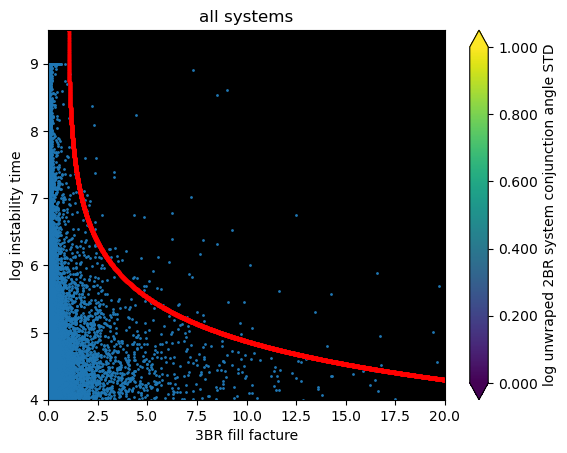

In [ ]:
ax = plt.axes()
plt.scatter((plot['threeBRfillfac']),np.log10(plot['instability_time']), s=1, c=(np.log10(plot['ThetaSTD']/1.8)), cmap=plt.cm.get_cmap("cool",7),vmin=0, vmax=1.5,alpha=.8)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")

plt.scatter(fillList, y,s=2, c = 'red')
ax.set_xlim([0,20])
ax.set_ylim([4,9.5])
plt.xlabel("3BR fill facture")
plt.ylabel("log instability time")
plt.title("all systems")
cbar.set_label('log unwraped 2BR system conjunction angle STD')
ax.set_facecolor("black")